In [2]:
import pyvisa as pv
import time
import sys
import numpy as np
import matplotlib.pyplot as 

rm = pv.ResourceManager()
print(rm.list_resources())
keysight = rm.open_resource(rm.list_resources()[0])
# keysight.read_termination = '\n'
# keysight.write_termination = '\n'
print(keysight.query('*IDN?'))
print(rm)
print(keysight)
keysight.write('*RST')
time.sleep(0.1)

('USB0::0x0957::0x8C18::MY51145486::INSTR', 'ASRL1::INSTR', 'ASRL6::INSTR')
Keysight Technologies,B2902A,MY51145486,3.4.2011.5100

Resource Manager of Visa Library at C:\WINDOWS\system32\visa32.dll
USBInstrument at USB0::0x0957::0x8C18::MY51145486::0::INSTR


Initializing process

In [3]:
current_compliance = 0.1
voltage_upper = 1

In [4]:
keysight.write(":SOUR:FUNC:MODE VOLT")
keysight.write(":SOUR:VOLT:RANG " + str(voltage_upper))
keysight.write(":SENSE:CURR:PROT " + str(current_compliance))


22

In [5]:
keysight.write("*RST")

6

Sourcing single voltage and measure current

In [6]:
'''
    code to measure current under voltage of 1V
'''
keysight.write("*RST")
keysight.write(":SOUR:FUNC:MODE VOLT")
keysight.write(":SOUR:VOLT -1")
keysight.write(":SENSE:CURR:PROT " + str(current_compliance))
keysight.write(":OUTP ON")
time.sleep(0.1)
keysight.write(":MEAS:CURR? (@1)")
data = keysight.read()
print(data)
time.sleep(0.1)
keysight.write(":OUTP OFF")
# time.sleep(0.1)
# print(keysight.query(":READ?"))

-9.999970E-02



11

In [7]:

keysight.write("*RST")
keysight.write(":SOUR1:FUNC:MODE VOLT")
keysight.write(":SOUR1:VOLT 1")
keysight.write(":OUTP1:LOW FLO")
keysight.write(":OUTP1 ON")

keysight.write(":SOUR2:FUNC:MODE VOLT")
keysight.write(":SOUR2:VOLT 1")

keysight.write(":OUTP2 ON")


11

In [8]:
keysight.close()

Staircase IV Measurement Setup

In [13]:
'''
code for sweep measurement
'''
# start = 0
# stop = 0.8
# points = 50
# nplc = 0.1 # aperture time of measurement. 0.1 by default
# current_compliance = 0.1

def single_IV_sweep(keysight, start, stop, points, nplc=0.1, current_compliance=0.1):
    '''
        Remember to initialze keysight and import numpy before executing this function!
        Runs an IV measurement on Channel 1.
        Return a numpy array with the current values.
    '''

    # Source
    keysight.write("*RST")
    keysight.write(":SOUR:FUNC:MODE VOLT")
    keysight.write(":SOUR:VOLT:MODE SWE")
    keysight.write(":SOUR:VOLT:STAR " + str(start))
    keysight.write(":SOUR:VOLT:STOP " + str(stop))
    keysight.write(":SOUR:VOLT:POIN " + str(points))

    # Measure
    keysight.write(":SENSE:FUNC ""CURR""")
    keysight.write(":SENSE:CURR:NPLC " + str(nplc))
    keysight.write(":SENSE:CURR:PROT " + str(current_compliance))

    # Trigger
    keysight.write(":TRIG:SOUR AINT")
    keysight.write(":TRIG:COUN " + str(points))

    # measurement
    keysight.write(":OUTP ON")
    keysight.write(":INIT (@1)")
    keysight.write(":FETC:ARR:CURR? (@1)")
    data = keysight.read()
    keysight.write(":OUTP OFF")

    # data convertion
    l = data.split(',')
    current_list = np.zeros(points, dtype=np.float64)
    for i in range(points):
        current_list[i] = float(l[i])

    return current_list

def MOSFET_IV_sweep(keysight, sd, g, nplc=0.1, sd_curr_comp=0.1, g_curr_comp=0.01):
    current_array = np.zeros((g[2], sd[2]))
    for i in range(g[2]):
        
        current_array[i] = single_IV_sweep(keysight, sd[0], sd[1], sd[2], nplc, sd_curr_comp)

    return current_array


Conduct the Staircase Measurement

In [11]:
# keysight.write(":OUTP ON")
# keysight.write(":INIT (@1)")
# keysight.write(":FETC:ARR:CURR? (@1)")
# data = keysight.read()
# keysight.write(":OUTP OFF")


In [12]:
# '''
#     Data convertion
# '''
# l = data.split(',')
# current_list = np.zeros(points, dtype=np.float64)
# for i in range(points):
#     current_list[i] = float(l[i])
# print(current_list)
# print(type(current_list))

In [10]:
plt.scatter(np.linspace(start, stop, points), current_list)
plt.title("Diode IV")
plt.show()

NameError: name 'start' is not defined

MOSFET IV Measurement

In [25]:
'''
    Source-Drain sweep
'''
SD_start = 0
SD_stop = 0.8
SD_points = 50
SD_curr_comp = 0.1 # Source-Drain current compliance, by default 0.1

'''
    Gate sweep
'''
G_start = 0
G_stop = 1
G_points = 5
G_curr_comp = 0.01 # gate current compliance, by default is 0.01

nplc = 0.1


gate_volt_list = np.outer(np.linspace(G_start, G_stop, G_points), np.ones(SD_points)).flatten()
gate_volt_list_str = np.array2string(gate_volt_list,separator=',', max_line_width=np.iinfo(np.int32).max, \
    threshold=np.iinfo(np.int32).max, floatmode='fixed')[1:-1]



# SD sweep setup
keysight.write("*RST")
keysight.write(":SOUR1:FUNC:MODE VOLT")
keysight.write(":SOUR1:VOLT:MODE SWE")
keysight.write(":SOUR1:VOLT:STAR " + str(SD_start))
keysight.write(":SOUR1:VOLT:STOP " + str(SD_stop))
keysight.write(":SOUR1:VOLT:POIN " + str(SD_points))

# gate sweep setup
keysight.write(":SOUR2:FUNC:MODE VOLT")
keysight.write(":SOUR2:VOLT:MODE LIST")
keysight.write(":SOUR2:LIST:VOLT " + gate_volt_list_str)

# current measurement setup
keysight.write(":SENSE:FUNC ""CURR""")
keysight.write(":SENS1:CURR:NPLC " + str(nplc))
keysight.write(":SENS1:CURR:PROT " + str(SD_curr_comp))
keysight.write(":SENS2:CURR:PROT " + str(G_curr_comp))

# trigger
keysight.write(":TRIG1:SOUR AINT")
keysight.write(":TRIG1:COUN " + str(SD_points * G_points))
keysight.write(":TRIG2:SOUR AINT")
keysight.write(":TRIG2:COUN " + str(SD_points * G_points))



17

In [26]:
keysight.write(":OUTP1 ON")
keysight.write(":OUTP2 ON")
keysight.write(":INIT (@1,2)")
keysight.write(":FETC:ARR:CURR? (@1)")
data = keysight.read()
keysight.write(":OUTP1 OFF")
keysight.write(":OUTP2 OFF")


12

In [13]:
l = data.split(',')
current_arr = np.zeros((G_points, SD_points), dtype=np.float64)
for i in range(G_points):
    for j in range(SD_points):
        current_arr[i,j] = float(l[i*G_points + j])


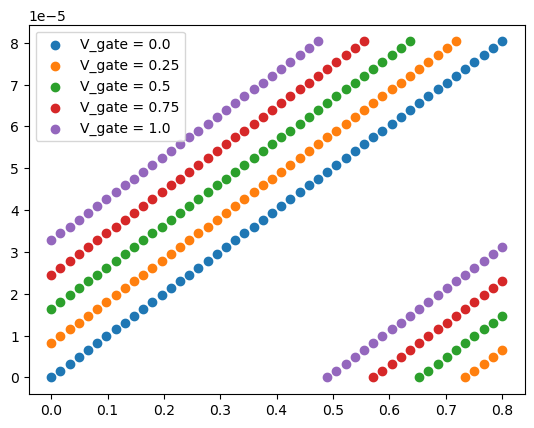

In [14]:
for i in range(G_points):
    plt.scatter(np.linspace(SD_start, SD_stop, SD_points), current_arr[i], \
                label="V_gate = " + str(np.linspace(G_start, G_stop, G_points)[i]))

plt.legend()
plt.show()

'0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.25000000,0.2500000

11

MOSFET IV Measurement (own version)

In [28]:
'''
    Source-Drain sweep
'''
SD_start = 0
SD_stop = 5
SD_points = 100
SD_curr_comp = 0.1 # Source-Drain current compliance, by default 0.1

'''
    Gate sweep
'''
G_start = 0
G_stop = 5
G_points = 5
G_curr_comp = 0.01 # gate current compliance, by default is 0.01
G_curr_list = np.linspace(G_start, G_stop, G_points)

nplc = 0.1

current_array = np.zeros((G_points, SD_points), dtype=np.float64)

# SD sweep setup

# gate sweep setup
# keysight.write(":SOUR2:FUNC:MODE VOLT")
# keysight.write(":SOUR2:VOLT:MODE LIST")
# keysight.write(":SOUR2:LIST:VOLT " + gate_volt_list_str)

# current measurement setup

# trigger
# keysight.write(":TRIG2:SOUR AINT")
# keysight.write(":TRIG2:COUN " + str(SD_points * G_points))


# Measurement

for i in range(G_points):
    keysight.write("*RST")
    keysight.write(":SOUR1:FUNC:MODE VOLT")
    keysight.write(":SOUR1:VOLT:MODE SWE")
    keysight.write(":SOUR1:VOLT:STAR " + str(SD_start))
    keysight.write(":SOUR1:VOLT:STOP " + str(SD_stop))
    keysight.write(":SOUR1:VOLT:POIN " + str(SD_points))

    keysight.write(":SENSE:FUNC ""CURR""")
    keysight.write(":SENS1:CURR:NPLC " + str(nplc))
    keysight.write(":SENS1:CURR:PROT " + str(SD_curr_comp))
    keysight.write(":SENS2:CURR:PROT " + str(G_curr_comp))

    keysight.write(":SOUR2:FUNC:MODE VOLT")
    keysight.write(":SOUR2:VOLT " + '%.5f' % G_curr_list[i])

    keysight.write(":TRIG1:SOUR AINT")
    keysight.write(":TRIG1:COUN " + str(SD_points))
    
    keysight.write(":OUTP2 ON")
    keysight.write(":OUTP1 ON")
    keysight.write(":INIT (@1,2)")
    keysight.write(":FETC:ARR:CURR? (@1)")
    data = keysight.read()
    keysight.write(":OUTP1 OFF")
    keysight.write(":OUTP2 OFF")

    l = data.split(',')
    for j in range(SD_points):
        current_array[i,j] = float(l[j])

    
keysight.write("*RST")



6

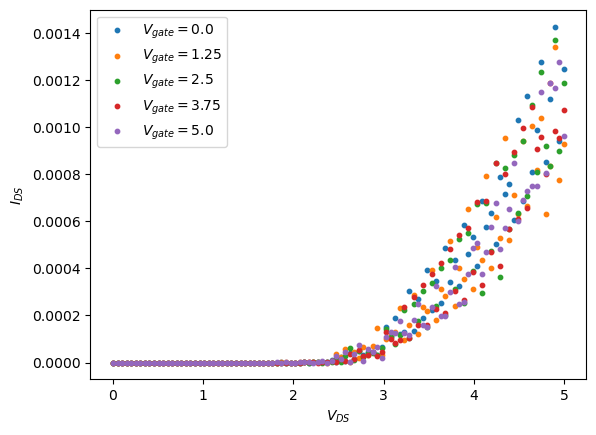

In [29]:
for i in range(G_points):
    plt.scatter(np.linspace(SD_start, SD_stop, SD_points), current_array[i], \
                label=r"$V_{gate} = $" + str(np.linspace(G_start, G_stop, G_points)[i]), s=10)

plt.legend()
plt.xlabel(r"$V_{DS}$")
plt.ylabel(r"$I_{DS}$")
plt.show()